<a href="https://colab.research.google.com/github/Br-alexis73/Face_recognition/blob/master/fr_orl_experiment_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'orl-faces:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1492577%2F2465716%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240421%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240421T103134Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D04cdad0072b37fa134a73af86b30905b4377d231439fae6eb42d3e9b80980b3e27c0c8e4a07dec26c2d8a4eb69f5af47fdfafcc84e5054de8b864b6f86d0a093f0f27d632485ce8dd0327810c02097241db0e18e3f99aabb43b238a4485022e510e56aeb23a2e939e804a0771797ad508db773577d3ea105f7e291cdf11a65d8be2f1068aa96e05e73ea6dfb663ec0149102346f7c6daa1e4ca35821bd269af2a42b56a79be94f060fc0a1e889cdb9ddb8570d10d2ae750607a03355ff694d746e385b9b5cc727920a69b368c43077d99c293bb4482a1de7af966e71c9966cd8c6e61a22b11ebd2b9ef15625181abe11662464fc4051b8bbce1d7c428f6c42c7'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 5666980 bytes downloaded
Downloaded and uncompressed: orl-faces
Data source import complete.


In [32]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
import itertools

# Step 2
Load Dataset :
After loading the Dataset you have to normalize every image.

**Note:** an image is a Uint8 matrix of pixels and for calculation, you need to convert the format of the image to float or double

In [33]:
#load dataset
data = np.load('../input/orl-faces/ORL_faces.npz')

# load the "Train Images"
x_train = data['trainX']
#normalize every image
x_train = np.array(x_train,dtype='float32')/255

x_test = data['testX']
x_test = np.array(x_test,dtype='float32')/255

# load the Label of Images
y_train= data['trainY']
y_test= data['testY']

# show the train and test Data format
print('x_train : {}'.format(x_train[:]))
print('Y-train shape: {}'.format(y_train))
print('x_test shape: {}'.format(x_test.shape))

x_train : [[0.1882353  0.19215687 0.1764706  ... 0.18431373 0.18039216 0.18039216]
 [0.23529412 0.23529412 0.24313726 ... 0.1254902  0.13333334 0.13333334]
 [0.15294118 0.17254902 0.20784314 ... 0.11372549 0.10196079 0.11372549]
 ...
 [0.44705883 0.45882353 0.44705883 ... 0.38431373 0.3764706  0.38431373]
 [0.4117647  0.4117647  0.41960785 ... 0.21176471 0.18431373 0.16078432]
 [0.45490196 0.44705883 0.45882353 ... 0.37254903 0.39215687 0.39607844]]
Y-train shape: [ 0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3
  4  4  4  4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5
  6  6  6  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9  9  9  9
 10 10 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11 11 11
 12 12 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 13 13
 14 14 14 14 14 14 1

# Step 3
Split DataSet : Validation data and Train

Validation DataSet: this data set is used to minimize overfitting.If the accuracy over the training data set increases, but the accuracy over then validation data set stays the same or decreases, then you're overfitting your neural network and you should stop training.

**Note:** we usually use 30 percent of every dataset as the validation data but Here we only used 5 percent because the number of images in this dataset is very low.

In [34]:
x_train, x_valid, y_train, y_valid= train_test_split(
    x_train, y_train, test_size=.05, random_state=1234,)

# **Step 4**

for using the CNN, we need to change The size of images ( The size of images must be the same)

In [35]:
im_rows = 112
im_cols = 92
batch_size = 512
im_shape = (im_rows, im_cols, 1)

# Change the size of images
x_train = x_train.reshape(x_train.shape[0], *im_shape)
x_test = x_test.reshape(x_test.shape[0], *im_shape)
x_valid = x_valid.reshape(x_valid.shape[0], *im_shape)

# Corrected print statements for the reshaped datasets
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('x_valid shape:', x_valid.shape)


x_train shape: (228, 112, 92, 1)
x_test shape: (160, 112, 92, 1)
x_valid shape: (12, 112, 92, 1)


# **Step 5**

Build CNN model: CNN have 3 main layer:

1-Convolotional layer
2- pooling layer
3- fully connected layer

we could build a new architecture of CNN by changing the number and position of layers.

In [36]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ZeroPadding2D


#filters= the depth of output image or kernels

cnn_model= Sequential([
    Conv2D(filters=36, kernel_size=7, activation='relu', input_shape= im_shape),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=54, kernel_size=5, activation='relu', input_shape= im_shape),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(2024, activation='relu'),
     Dropout(0.5),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    #20 is the number of outputs
    Dense(20, activation='softmax')
])

cnn_model.compile(
    loss='sparse_categorical_crossentropy',#'categorical_crossentropy',
    optimizer=Adam(lr=0.0001),
    metrics=['accuracy']
)
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 106, 86, 36)       1800      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 53, 43, 36)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 49, 39, 54)        48654     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 24, 19, 54)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 24624)             0         
                                                                 
 dense_4 (Dense)             (None, 2024)             


Show the model's parameters.

Step 6
Train the Model

Note: You can change the number of epochs

In [37]:
history=cnn_model.fit(
    np.array(x_train), np.array(y_train), batch_size=512,
    epochs=100, verbose=2,
    validation_data=(np.array(x_valid),np.array(y_valid)),
)

Epoch 1/100
1/1 - 2s - loss: 3.0096 - accuracy: 0.0526 - val_loss: 3.1911 - val_accuracy: 0.0000e+00 - 2s/epoch - 2s/step
Epoch 2/100
1/1 - 0s - loss: 3.2326 - accuracy: 0.0526 - val_loss: 3.0123 - val_accuracy: 0.0833 - 144ms/epoch - 144ms/step
Epoch 3/100
1/1 - 0s - loss: 3.0609 - accuracy: 0.0789 - val_loss: 3.0053 - val_accuracy: 0.0833 - 119ms/epoch - 119ms/step
Epoch 4/100
1/1 - 0s - loss: 2.9773 - accuracy: 0.0702 - val_loss: 3.0008 - val_accuracy: 0.0833 - 116ms/epoch - 116ms/step
Epoch 5/100
1/1 - 0s - loss: 2.9778 - accuracy: 0.0833 - val_loss: 2.9945 - val_accuracy: 0.0833 - 107ms/epoch - 107ms/step
Epoch 6/100
1/1 - 0s - loss: 2.9673 - accuracy: 0.1096 - val_loss: 2.9917 - val_accuracy: 0.0833 - 104ms/epoch - 104ms/step
Epoch 7/100
1/1 - 0s - loss: 2.9557 - accuracy: 0.1140 - val_loss: 2.9899 - val_accuracy: 0.0000e+00 - 109ms/epoch - 109ms/step
Epoch 8/100
1/1 - 0s - loss: 2.9339 - accuracy: 0.1140 - val_loss: 2.9694 - val_accuracy: 0.0000e+00 - 106ms/epoch - 106ms/step
Ep

Evaluate the test data

In [38]:
scor = cnn_model.evaluate( np.array(x_test),  np.array(y_test), verbose=0)

print('test los {:.4f}'.format(scor[0]))
print('test acc {:.4f}'.format(scor[1]))

test los 0.3317
test acc 0.9563


# Step 7
plot the result

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


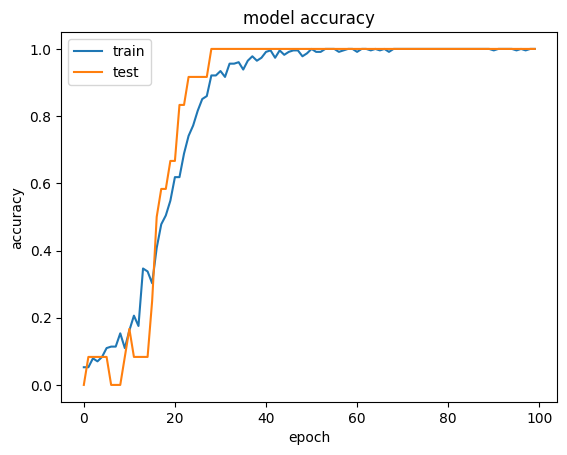

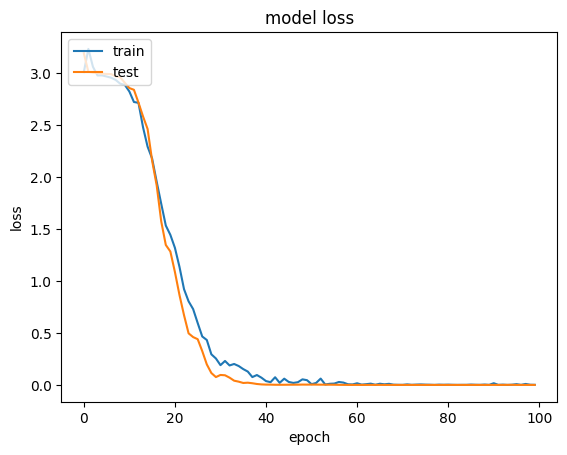

In [39]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# step 8
Plot Confusion Matrix

5/5 [==============================] - 0s 4ms/step


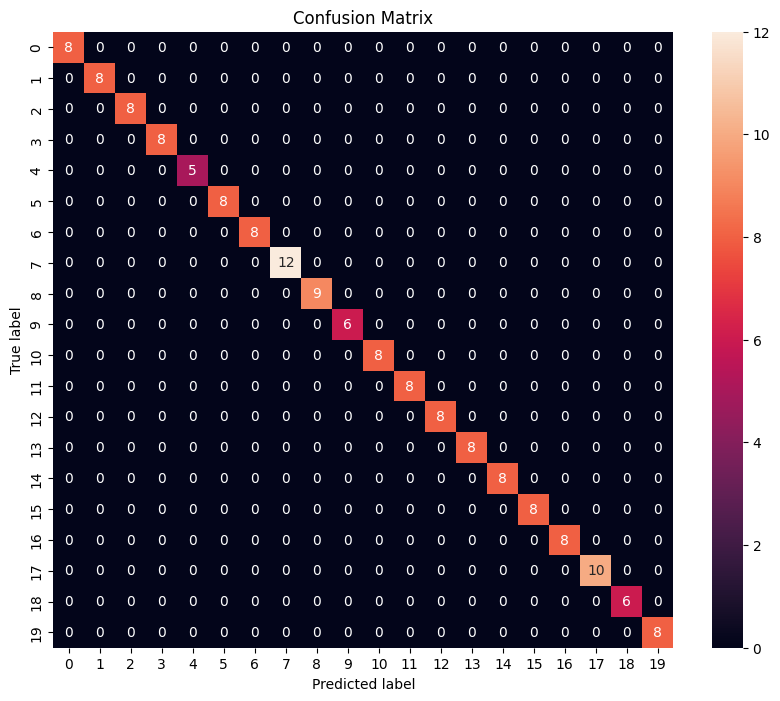

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         8
           6       1.00      1.00      1.00         8
           7       1.00      1.00      1.00        12
           8       1.00      1.00      1.00         9
           9       1.00      1.00      1.00         6
          10       1.00      1.00      1.00         8
          11       1.00      1.00      1.00         8
          12       1.00      1.00      1.00         8
          13       1.00      1.00      1.00         8
          14       1.00      1.00      1.00         8
          15       1.00      1.00      1.00         8
          16       1.00      1.00      1.00         8
          17       1.00    

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

predicted =np.argmax(cnn_model.predict(x_test), axis=-1)

#print(predicted)
#print(y_test)
y_prob = cnn_model.predict(x_test)  # This will give you the class probabilities.
y_pred = np.argmax(y_prob, axis=1)

# Compute the confusion matrix

conf_matrix = confusion_matrix(predicted, y_pred)

# Plotting the confusion matrix with seaborn to have a similar look as the provided screenshot
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

# Generate and print the classification report
report = classification_report(predicted, y_pred)
print(report)